In [ ]:
#importing path from drive
folder_path = '/content/drive/MyDrive/data/'
#!ls {folder_path}

In [ ]:
import pandas as pd
file_path = folder_path + 'thyroid_cleaned_num.csv'
df = pd.read_csv(file_path)

print(df.head())

   age        TSH   T3    TT4   T4U    FTI  target_encoded
0   61   9.799999  1.2  114.0  0.84  136.0               3
1   27  90.000000  0.4    7.5  0.94    7.5               2
2   40  70.000000  0.4    3.9  0.83    5.0               2
3   57   0.250000  4.2  236.0  0.70  337.0               0
4   44   8.400000  1.8  108.0  1.01  107.0               3


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def diffble_argmax(input, beta=100):
    *_, n = input.shape
    input = nn.functional.softmax(beta * input, dim=-1)
    indices = torch.linspace(0, 1, n)
    result = torch.sum((n - 1) * input * indices, dim=-1)
    return result

torch.manual_seed(42)

class DecisionMaker:
    def __init__(self, criteria, alternatives):
        self.no_criteria = len(criteria)
        self.no_alternatives = len(alternatives)
        self.criteria = criteria
        self.alternatives = alternatives
        self.reinit()

    def reinit(self):
        self.weights = torch.empty(1, self.no_criteria, 3)
        self.tuple_mat = torch.empty(self.no_alternatives, self.no_criteria, 3)
        self.tuple_weights = torch.empty(1, self.no_criteria, 3)
        self.matrix = torch.empty(self.no_alternatives, self.no_criteria, dtype=torch.long)


    def set_ip(self):
        for i in range(self.no_alternatives):
            for j in range(self.no_criteria):
                entry = self.matrix[j][i].unsqueeze(0)
                new_entry = torch.cat((entry + 1, entry + 2, entry + 3))
                self.tuple_mat[i][j] = new_entry


        self.load_weights()

    def load_weights(self):
      for k in range(self.no_criteria):
            self.tuple_weights[0][k] = torch.tensor((k+1, k +2, k + 3))

    def load_comb_weights(self):
      for k in range(self.no_criteria):
            m = torch.round(self.weights[k] * 10).unsqueeze(0)
            m = torch.cat((m, m+1, m+2), 0)
            self.tuple_weights[0][k] = m




    def display_state(self):
        print(self.matrix.t())

    def display_weights(self):
        print(self.weights)

class FuzzyTopsis:
    def __init__(self, criteria, alternatives, no_dms):
        self.no_criteria = len(criteria)
        self.no_alternatives = len(alternatives)
        self.criteria = criteria
        self.alternatives = alternatives
        self.no_dms = no_dms
        self.combined_dm = None
        self.dms = [DecisionMaker(criteria, alternatives) for _ in range(no_dms)]
        self.fpis = self.fnis = None
        self.inputs = None
        self.display = False


    def calc_fpis_fnis_mats(self):
        self.fpis = torch.empty(self.no_alternatives, self.no_criteria)
        self.fnis = torch.empty(self.no_alternatives, self.no_criteria)
        for i, col in enumerate(self.combined_dm.tuple_mat):
            Ap = col[0]
            An = col[0]
            for entry in col:
                if torch.gt(entry, Ap).any():
                    Ap = entry
                if torch.lt(entry, An).any():
                    An = entry
            fp = fuzzy_dist(Ap.unsqueeze(0), col)
            fn = fuzzy_dist(An.unsqueeze(0), col)

            self.fpis[i] = fp
            self.fnis[i] = fn


    def display_fnis_fpis(self):
        print("fpis weighted mat")
        print(self.fpis)
        print("fnis weighted mat")
        print(self.fnis)

    def display_state_mat(self):
        for i, dm in enumerate(self.dms):
            print("Decision Maker ", i)
            dm.display_state()

    def display_weight_comb(self):
        print("Decision Makers combined weights")
        self.combined_dm.display_weights()

    def apply_weights(self):
        temp = torch.cat((self.combined_dm.tuple_weights,self.combined_dm.tuple_weights,self.combined_dm.tuple_weights,self.combined_dm.tuple_weights), 0)
        self.combined_dm.tuple_mat = torch.mul(temp, self.combined_dm.tuple_mat)

    def normalize(self):
        min_set = torch.max(self.combined_dm.tuple_mat[:, :, 2], dim=0)[0].unsqueeze(0).unsqueeze(2)
        self.combined_dm.tuple_mat = torch.div(self.combined_dm.tuple_mat, min_set)



    def calc_cci(self):
        dip = torch.sum(self.fpis, dim=1)
        din = torch.sum(self.fnis, dim=1)
        self.cci = din / (din + dip)

    def aggregate(self):
        for i in range(self.no_alternatives):
            for j in range(self.no_criteria):
                min_vals = [dm.tuple_mat[i][j][0] for dm in self.dms]
                self.combined_dm.tuple_mat[i][j][0] = torch.min(torch.stack(min_vals))

                avg_vals = [dm.tuple_mat[i][j][1] for dm in self.dms]
                self.combined_dm.tuple_mat[i][j][1] = torch.mean(torch.stack(avg_vals))

                max_vals = [dm.tuple_mat[i][j][2] for dm in self.dms]
                self.combined_dm.tuple_mat[i][j][2] = torch.max(torch.stack(max_vals))


    def eval(self):
        self.aggregate()
        if self.display:
          print()
          self.display_state_mat()
          print()
          self.display_weight_comb()
          print()

        self.normalize()
        self.apply_weights()
        self.calc_fpis_fnis_mats()
        self.calc_cci()
        max_index = torch.argmax(self.cci)
        return max_index, self.cci[max_index], self.cci


    def update_matrices(self, model_output, weights):
        self.inputs = model_output
        self.combined_dm = DecisionMaker(self.criteria, self.alternatives)
        for i, matrix_output in enumerate(model_output):
            dm = self.dms[i]
            dm.reinit()
            dm.matrix = matrix_output
            dm.set_ip()


        self.combined_dm.weights = weights
        self.combined_dm.load_comb_weights()


def fuzzy_dist(a, b):
    return torch.sqrt(torch.mean((a - b) ** 2))


class DeepQNetFuzzy(nn.Module):
    def __init__(self, num_networks=6):
        super().__init__()
        self.num_networks = num_networks
        self.networks = nn.ModuleList([self.create_network() for _ in range(num_networks)])
        self.ft = ft = FuzzyTopsis(column_names, range(no_classes), 1)
        self.weights = nn.Linear(1, 6)

    def display(self, val):
      self.ft.display = val

    def create_network(self):
        return nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )

    def forward(self, x, dummy):
      y = torch.tensor([])
      for i, network in enumerate(self.networks):
          z = x[i].unsqueeze(0)
          outputs = network(z)

          predicted_classes = torch.sigmoid(outputs) * 5
          y = torch.cat((y, predicted_classes.unsqueeze(0)),0)

      y = y.unsqueeze(dim = 0)
      weights = self.weights(dummy)

      self.ft.update_matrices(y, weights)



      max_index, cci_max, cci_list = self.ft.eval()
      return max_index, cci_list


target_class = 'target_encoded'
no_classes = df[target_class].max() + 1

column_names = df.columns.tolist()
if target_class in column_names:
  column_names.remove(target_class)

mod = DeepQNetFuzzy()

dummy = torch.tensor([1.0], requires_grad = True)

ip = torch.tensor([0, 1, 3, 5, 4.7, 2.9], requires_grad=True)
print("$input", ip)
op = mod(ip, dummy)
print("$output", op)

$input tensor([0.0000, 1.0000, 3.0000, 5.0000, 4.7000, 2.9000], requires_grad=True)
$output (tensor(1), tensor([0.5581, 0.5940, 0.5530, 0.5444], grad_fn=<DivBackward0>))


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Step 1: Data Preprocessing
file_path = folder_path + 'thyroid_cleaned_num.csv'
df = pd.read_csv(file_path)

# Feature columns (X) and target column (y)
X = df.drop(columns=['target_encoded']).values
y = df['target_encoded'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Create Dataset and DataLoader
class ThyroidDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 1
train_dataset = ThyroidDataset(X_train, y_train)
test_dataset = ThyroidDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Step 4: Define Loss Function and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = DeepQNetFuzzy()
model.to(device)
dummy = dummy.to(device)


loss_list = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0025)#.005

In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# Assuming train_dataset is your training dataset

# Calculate class weights
class_counts = {}  # Dictionary to store counts of each class
for _, label in train_dataset:
    label = label.item()  # Convert tensor label to integer
    class_counts[label] = class_counts.get(label, 0) + 1

print(class_counts)


class_weights = [1.0 / class_counts[label.item()]**3  for _, label in train_dataset]

# Calculate weights for each sample
weights = [class_weights[label.item()] for _, label in train_dataset]

# Create sampler
sampler = WeightedRandomSampler(weights, len(train_dataset), replacement=True)

# Define other DataLoader parameters
batch_size = 1
shuffle = False  # Shuffle is handled by the sampler

# Create DataLoader with the sampler
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)




{3: 162, 2: 133, 0: 79, 1: 13}


In [ ]:

# Initialize a dictionary to store class counts
class_counts_loader = {label: 0 for label in range(4)}  # Assuming num_classes is the total number of classes

# Iterate through the data loader batches
for batch_data, batch_labels in train_loader:
    # Calculate class counts within the current batch
    for label in batch_labels:
        label = label.item()  # Convert tensor label to integer
        class_counts_loader[label] += 1  # Increment the count for the corresponding class label

# Print class counts
print("Class Counts in the Loader:")
for label, count in class_counts_loader.items():
    print(f"Class {label}: {count}")

Class Counts in the Loader:
Class 0: 87
Class 1: 14
Class 2: 111
Class 3: 175


In [ ]:
# Step 5: Training Loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        _, outputs = model(inputs.squeeze(), dummy)
        outputs = outputs.unsqueeze(0)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        loss_list.append(loss.item())



    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/3], Loss: 1.3642


Epoch [2/3], Loss: 1.3359


Epoch [3/3], Loss: 1.3188


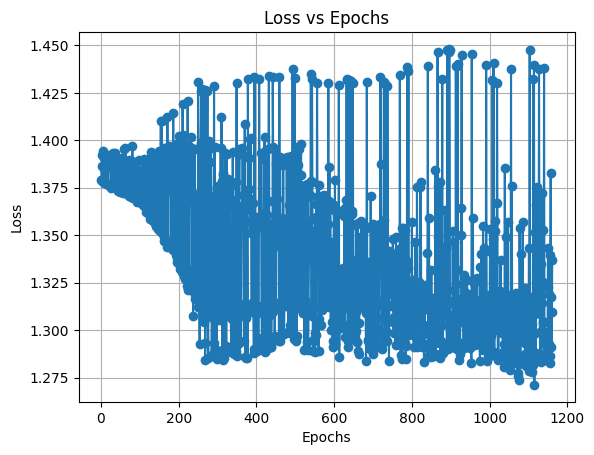

In [ ]:
import matplotlib.pyplot as plt

# Example loss list and epochs
epochs = range(1, len(loss_list) + 1)

# Plot loss vs epochs
plt.plot(epochs, loss_list, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Set the model to evaluation mode
model.eval()
model.display(False)
total = 0
correct = 0

# Iterate through the test DataLoader to get predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        _, outputs = model(inputs.squeeze(), dummy)
        outputs = outputs.unsqueeze(0)

        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        pred_labels.extend(predicted.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

# Compute accuracy
accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")


Confusion Matrix:
[[14  0  0  0]
 [ 3  0  0  0]
 [ 0  0 18 13]
 [ 0  0  0 49]]
Accuracy on test set: 83.51%


In [ ]:
model

DeepQNetFuzzy(
  (networks): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features=8, out_features=4, bias=True)
    )
  )
  (weights): Linear(in_features=1, out_features=6, bias=True)
)